,0,1,2,3,4,5,6
0,0.0000,0.0063,0.0027,0.0054,0.0138,0.0043,0.0137
1,0.0051,0.0000,0.0040,0.0252,0.0150,0.0216,0.0051
2,0.0070,0.0056,0.0000,0.0065,0.0262,0.0044,0.0105
3,0.0097,0.0334,0.0055,0.0000,0.0034,0.0085,0.0023
4,0.0088,0.0039,0.0081,0.0072,0.0000,0.0016,0.0147
5,0.0045,0.0084,0.0043,0.0138,0.0204,0.0000,0.0045
6,0.0043,0.0129,0.0024,0.0058,0.0101,0.0069,0.0000


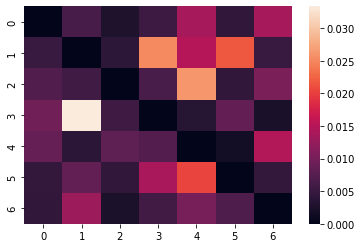

In [1]:
import pandas as pd
import numpy as np
from tsdata_to_var_torch import tsdata_to_var_torch
from var_to_autocov_torch import var_to_autocov_torch
from autocov_to_pwcgc_torch import autocov_to_pwcgc_torch
import seaborn as sns
import torch



X = pd.read_csv('X.csv',header=None)
X  = np.array(X).T # X must be numpy array in shape of (num var, num rows)
X = torch.tensor(X)

p=3
A, SIG, E = tsdata_to_var_torch(X, p)
G= var_to_autocov_torch(A,SIG, q = 100)
F = autocov_to_pwcgc_torch(G,SIG)
F = np.array(F)

np.fill_diagonal(F,0)
sns.heatmap(F)
pd.DataFrame(np.round(F,4))


In [109]:
import torch




X = pd.read_csv('X.csv',header=None)
X  = np.array(X)
X = torch.tensor(X, requires_grad=True)


device = torch.device('cpu')
dtype = torch.float64
X = X.to(device=device, dtype=dtype)
clamp_eps = 1e-12
import torch



def laplacian_eigendecomp_from_data(
    X,
    normalized: bool = False,
    keep_only_positive: bool = False,
    clamp_eps: float = 1e-12,
    device=None,
    dtype=None,
):
    """
    Build a feature–feature graph from correlations, then compute Laplacian eigendecomposition.

    Args
    ----
    X : (N, D) tensor
        Data matrix: N samples, D features.
    normalized : bool
        If False -> unnormalized Laplacian L = D - A.
        If True  -> symmetric normalized Laplacian L = I - D^{-1/2} A D^{-1/2}.
    keep_only_positive : bool
        If True, negative correlations are clamped to 0 (standard nonnegative-edge Laplacian).
        If False, A keeps signs (L may not be PSD).
    clamp_eps : float
        Numerical floor to avoid division by zero (stds, degrees).
    device, dtype :
        Optional overrides for output tensors.

    Returns
    -------
    evals : (D,) tensor
        Eigenvalues (ascending = low frequency first).
    evecs : (D, D) tensor
        Eigenvectors as columns (orthonormal).
    A     : (D, D) tensor
        Correlation-derived adjacency used (diag set to 0).
    L     : (D, D) tensor
        Laplacian actually diagonalized.
    """
    if device is None:
        device = X.device
    if dtype is None:
        dtype = X.dtype
    X = X.to(device=device, dtype=dtype)

    N, D = X.shape

    # ----- 1) Correlation adjacency A (D x D) -----
    # Center features
    Xc = X - X.mean(dim=0, keepdim=True)                 # (N, D)
    # Unbiased std (N-1), clamp to avoid divide-by-zero
    std = Xc.std(dim=0, unbiased=True).clamp_min(clamp_eps)  # (D,)
    # Covariance
    cov = (Xc.T @ Xc) / max(N - 1, 1)                    # (D, D)
    # Pearson correlation
    A = cov / (std.unsqueeze(1) * std.unsqueeze(0))      # (D, D)
    # Enforce symmetry + diag=1 (numerical hygiene)
    A = 0.5 * (A + A.T)
    A.fill_diagonal_(1.0)

    # Optionally drop negative edges for a standard nonnegative-weight graph
    if keep_only_positive:
        A = torch.clamp(A, min=0.0)

    # Remove self-loops for adjacency (standard for Laplacian)
    A = A.clone()
    A.fill_diagonal_(0.0)

    # ----- 2) Degrees -----
    deg = torch.abs(A).sum(dim=1)                                   # (D,)
    Dmat = torch.diag(deg)                               # (D, D)


    # ----- 3) Laplacian -----
    if not normalized:
        # Unnormalized: L = D - A
        L = Dmat - A

    else:
        # Symmetric normalized: L = I - D^{-1/2} A D^{-1/2}
        d_safe = deg.clamp_min(clamp_eps)
        Dm12 = torch.diag(1.0 / torch.sqrt(d_safe))      # (D, D)
        L = torch.eye(D, device=device, dtype=dtype) - (Dm12 @ A @ Dm12)

    # ----- 4) Eigen-decomposition (symmetric/Hermitian) -----
    # torch.linalg.eigh assumes symmetry and returns ascending eigenvalues
    evals, evecs = torch.linalg.eigh(L)

    return evals, evecs, A, L



def subspace_loss_principal_angles(U1, U2):
    """
    U1, U2: (D, k) with orthonormal columns (e.g., first k Laplacian eigenvectors)
    Returns: loss in [0, 1], and principal cosines (singular values) for inspection.
e Grassmann (principal-angles) loss — a
        """
    # Cross-gram: k x k
    M = U1.T @ U2

    # Principal cosines = singular values of M (all in [0,1])
    s = torch.linalg.svdvals(M)  # (k,)

    # Average sin^2(theta) = 1 - mean(cos^2(theta))
    loss = 1.0 - (s**2).mean()
    return loss, s  # s are cos(theta_i)

# evals_n, U, A_n, L_n = laplacian_eigendecomp_from_data(X, normalized=False)
# print("Normalized:   eigenvalues:", evals_n)


L = X.shape[0]


chunks = []
for i in range(5):
    X_i = X[L//5 * i : L//5 * (i+1)]
    chunks.append(X_i)

# Stack along a new axis
X = torch.stack(chunks, dim=0)


# evals_n1, U1, A_n, L_n = laplacian_eigendecomp_from_data(X1, normalized=False)


# X2 = X[L//2:]
# evals_n2, U2, A_n, L_n = laplacian_eigendecomp_from_data(X2, normalized=False)

# # k = 3 /
# # U1= U1[:, -k:]  
# # U2 = U2[:, -k:]  


# loss , _ = subspace_loss_principal_angles(U1, U2)

# loss.backward()



In [110]:
X.shape

torch.Size([5, 144, 7])

In [116]:
import torch
from typing import Tuple, Literal

@torch.no_grad()
def _make_eye(B: int, D: int, device, dtype):
    I = torch.eye(D, device=device, dtype=dtype)
    return I.expand(B, D, D)

def laplacian_eigendecomp_batched(
    X: torch.Tensor,                         # (B, N, D)
    normalized: bool = False,
    keep_only_positive: bool = False,
    clamp_eps: float = 1e-12,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Batched version of your function.
    Returns:
      evals: (B, D), evecs: (B, D, D) [evecs columns], A: (B, D, D), L: (B, D, D)
    """
    B, N, D = X.shape
    device, dtype = X.device, X.dtype
    I = _make_eye(B, D, device, dtype)

    # 1) Correlation adjacency per batch
    Xc   = X - X.mean(dim=1, keepdim=True)                      # (B, N, D)
    std  = Xc.std(dim=1, unbiased=True).clamp_min(clamp_eps)    # (B, D)
    # Covariance: (Xc^T Xc) / (N-1)
    cov  = torch.matmul(Xc.transpose(1, 2), Xc) / max(N - 1, 1) # (B, D, D)
    A    = cov / (std.unsqueeze(-1) * std.unsqueeze(-2))        # (B, D, D)
    A    = 0.5 * (A + A.transpose(-1, -2))                      # symmetrize
    # set diag to 1.0, then remove self-loops for Laplacian adjacency
    A    = A * (1 - I) + I
    if keep_only_positive:
        A = torch.clamp(A, min=0.0)
    A = A * (1 - I)                                            # remove self loops

    # 2) Degree
    deg  = A.abs().sum(dim=-1)                                  # (B, D)
    Dmat = torch.diag_embed(deg)                                # (B, D, D)

    # 3) Laplacian
    if not normalized:
        L = Dmat - A                                            # (B, D, D)
    else:
        d_safe = deg.clamp_min(clamp_eps)
        dinv2  = 1.0 / torch.sqrt(d_safe)                       # (B, D)
        Dm12   = torch.diag_embed(dinv2)                        # (B, D, D)
        L      = I - torch.matmul(torch.matmul(Dm12, A), Dm12)  # (B, D, D)

    # 4) Eigendecomposition (batched, symmetric)
    # torch.linalg.eigh supports batches; returns ascending eigenvalues
    evals, evecs = torch.linalg.eigh(L)                         # (B, D), (B, D, D)
    return evals, evecs, A, L

def take_first_k_evecs(evecs: torch.Tensor, k: int) -> torch.Tensor:
    """
    evecs: (B, D, D) with eigenvectors in columns (as from eigh).
    Returns U: (B, D, k) the first k eigenvectors (low-frequency).
    """
    return evecs[:, :, :k].contiguous()

def subspace_loss_principal_angles_batched(
    U1: torch.Tensor,      # (B, D, k) orthonormal columns
    U2: torch.Tensor,      # (B, D, k) orthonormal columns
    reduction: Literal["mean", "sum", "none"] = "mean"
):
    """
    Batched Grassmann loss: 1 - mean(cos^2 theta) per batch, where cosines are
    singular values of U1^T U2. Returns:
      loss: () if reduced, else (B,)
      cosines: (B, k)
    """
    # Cross-gram per batch: (B, k, k)
    M = torch.einsum('bdk,bdm->bkm', U1, U2)
    s = torch.linalg.svdvals(M)                  # (B, k), values in [0,1]
    batch_loss = 1.0 - (s ** 2).mean(dim=-1)     # (B,)
    if reduction == "mean":
        return batch_loss.mean(), s
    elif reduction == "sum":
        return batch_loss.sum(), s
    else:
        return batch_loss, s

# ---- Example wiring (no loops) ----
# X1, X2 are (B, N, D) two datasets you want to compare the k-dim Laplacian subspaces for
evals1, evecs1, A, L = laplacian_eigendecomp_batched(X, normalized=True)
evals2, evecs2, *_ = laplacian_eigendecomp_batched(X, normalized=True)

# U1 = take_first_k_evecs(evecs1, k)   # (B, D, k)
# U2 = take_first_k_evecs(evecs2, k)   # (B, D, k)
loss, cosines = subspace_loss_principal_angles_batched(evecs1, evecs2, reduction="mean")




loss.backward()


In [95]:
import torch

def subspace_loss_principal_angles(U1, U2):
    """
    U1, U2: (D, k) with orthonormal columns (e.g., first k Laplacian eigenvectors)
    Returns: loss in [0, 1], and principal cosines (singular values) for inspection.
    """
    # Cross-gram: k x k
    M = U1.T @ U2

    # Principal cosines = singular values of M (all in [0,1])
    s = torch.linalg.svdvals(M)  # (k,)

    # Average sin^2(theta) = 1 - mean(cos^2(theta))
    loss = 1.0 - (s**2).mean()
    return loss, s  # s are cos(theta_i)


def subspace_loss_projection(U1, U2):
    P1 = U1 @ U1.T
    P2 = U2 @ U2.T
    fro2 = torch.linalg.matrix_norm(P1 - P2, ord='fro')**2
    # Normalize by k to keep scale comparable across k
    return (fro2 / U1.shape[1])

def eigenvectorwise_loss_procrustes(U1, U2):
    """
    Align U1 to U2 via an optimal orthogonal Q, then compare columns one-by-one.
    """
    # Solve: max_Q trace((U1^T U2) Q), Q orthogonal -> Q = U V^T where (U,S,Vt) = SVD(U1^T U2)
    M = U1.T @ U2
    U, _, Vt = torch.linalg.svd(M)
    Q = U @ Vt  # (k, k)
    U1_aligned = U1 @ Q

    # Column-wise cosine similarities (should be ~1 if perfectly aligned)
    # diag of (U1_aligned^T U2) are the cosines after alignment
    diag_cos = torch.diag(U1_aligned.T @ U2)
    loss = 1.0 - diag_cos.mean().clamp(min=-1.0, max=1.0)
    return loss, diag_cos


loss_subspace, principal_cos = subspace_loss_principal_angles(U1, U2)
print("Subspace loss (principal angles):", float(loss_subspace))
# print("Principal cosines:", principal_cos.tolist())

# Optional alternative:
loss_proj = subspace_loss_projection(U1, U2)
print("Projection loss:", float(loss_proj))

# Optional vector-wise view (after best rotation):
loss_vecwise, diag_cos = eigenvectorwise_loss_procrustes(U1, U2)
print("Vector-wise (after Procrustes) loss:", float(loss_vecwise))
# print("Aligned column cosines:", diag_cos.tolist())


Subspace loss (principal angles): 1.1102230246251565e-16
Projection loss: 1.1703751527203171e-30
Vector-wise (after Procrustes) loss: 0.0


In [117]:
from typing import Optional, Tuple, Dict
import torch

def schur_torch(A1):
    Q_total = torch.eye(A1.size()[0], dtype=A1.dtype, device=A1.device)
    
    T = A1.clone()

    for _ in range(30000):
        # 1. Perform QR decomposition on the current matrix
        # We use torch.linalg.qr, as torch.qr is deprecated.
        Q, R = torch.linalg.qr(T)
        
        # 2. Recombine as R @ Q
        # This new matrix is similar to the original A
        # and converges to the upper-triangular Schur form T.
        T = R @ Q
        
        # 3. Accumulate the orthogonal transformations
        Q_total = Q_total @ Q

    return T, Q_total



def _vecF(M: torch.Tensor) -> torch.Tensor:
    # Fortran-style vec (stack columns)
    return M.transpose(0, 1).contiguous().reshape(-1, 1)

def _unvecF(v: torch.Tensor, n: int, m: int) -> torch.Tensor:
    # Inverse of _vecF
    return v.reshape(m, n).transpose(0, 1).contiguous()

def lyapslv_torch(A: torch.Tensor, Q: torch.Tensor) -> torch.Tensor:
    """
    Solve discrete-time Lyapunov via real Schur:
        X = A X A^T + Q
    using the column-wise block back-substitution (as in your NumPy/Scipy code).

    Args:
        A: (n,n) real tensor
        Q: (n,n) real tensor
        schur_fn: callable returning (T, U) where A = U @ T @ U.T (real Schur)

    Returns:
        X: (n,n) real tensor
    """
    device = A.device
    dtype  = A.dtype
    n = A.shape[0]

    # Real Schur
    T, U = schur_torch(A)  # both (n,n)

    # Flip signs to make diag(U) >= 0 where possible
    s = torch.sign(torch.real(torch.diag(U)))
    s = torch.where(s == 0, torch.ones_like(s), s)
    S = torch.diag(s)

    U = U @ S
    T = S.T @ T @ S  # S is ±1 diagonal so S.T==S

    # Transform Q
    Qs = -(U.T @ Q @ U)

    Xs = torch.zeros((n, n), dtype=dtype, device=device)

    j = n
    # small tolerance to detect 2x2 blocks in quasi-upper-triangular T
    tol = torch.finfo(dtype).eps * 10

    while j > 0:
        j1 = j
        # detect 2x2 block if subdiagonal entry is (numerically) nonzero
        if j == 1:
            bsiz = 1
        elif torch.abs(T[j-1, j-2]) > tol:
            bsiz = 2
            j = j - 1  # include the (j-1)-th column as part of this 2x2 block
        else:
            bsiz = 1

        bsizn = bsiz * n

        # Kronecker system: (kron(T_jj, T) - I) vec(X(:, j..j1)) = rhs
        Tjj = T[j-1:j1, j-1:j1]                               # (bsiz, bsiz)
        Ajj = torch.kron(Tjj, T) - torch.eye(bsizn, dtype=dtype, device=device)

        rhs = _vecF(Qs[:, j-1:j1])                            # (bsizn, 1)

        # Add coupling to already-computed columns (to the right)
        if j1 < n:
            add_term = T @ (Xs[:, j1:n] @ T[j-1:j1, j1:n].T)  # (n, bsiz)
            rhs = rhs + _vecF(add_term)

        v = -torch.linalg.solve(Ajj, rhs)                     # (bsizn, 1)

        # Fill current column(s)
        Xs[:, j-1] = v[:n, 0]
        if bsiz == 2:
            Xs[:, j1-1] = v[n:bsizn, 0]

        j -= 1

    # Transform back
    X = U @ Xs @ U.T
    return X





def _torch_demean(X: torch.Tensor, normalize: bool = False):
    """
    X: (n, m, N)
    Demean across the 'sample' axis collectively over trials, i.e., per variable (row)
    over all m*N samples. Matches MATLAB-style:
       Y = X(:,:); Y = Y - mean(Y,2)*ones(1,N*m); reshape back.
    """
    n, m, N = X.shape
    Y = X.reshape(n, m * N)
    mu = Y.mean(dim=1, keepdim=True)            # (n,1)
    Y = Y - mu
    if normalize:
        # unbiased=False here (population std) to mirror common MATLAB behavior unless you want ddof=1
        sd = Y.std(dim=1, keepdim=True, unbiased=False).clamp_min(1e-12)
        Y = Y / sd
    return Y.reshape(n, m, N)


def _chol_with_jitter(S, max_tries=5, jitter_scale=1e-10):
    """
    Robust Cholesky with trace-based jitter fallback.
    """
    n = S.shape[-1]
    trace_S = torch.trace(S).clamp_min(0.0)
    jitter = 0.0
    for _ in range(max_tries):
        try:
            return torch.linalg.cholesky(S + jitter * torch.eye(n, dtype=S.dtype, device=S.device))
        except RuntimeError:
            # Increase jitter (geometric)
            jitter = jitter_scale * (trace_S / max(n, 1)) * (10.0 if jitter > 0 else 1.0)
            if jitter == 0.0:  # handle trace 0
                jitter = jitter_scale
    # Final attempt may still fail and raise, which is fine (surface the error)
    return torch.linalg.cholesky(S + jitter * torch.eye(n, dtype=S.dtype, device=S.device))


def tsdata_to_var_torch(X, p: int, dtype=torch.float64, device=None):

    """
    PyTorch implementation of your tsdata_to_var.

    Args:
        X: array-like (n, m) or (n, m, N). If (n, m), a singleton trial dim is added.
        p: VAR order
        dtype: torch dtype (default float64 for stability)
        device: torch device (inferred from X if torch.Tensor; else cpu)

    Returns:
        A: (n, n, p)  VAR coefficients (Torch tensor)
        SIG: (n, n)   residual covariance (Torch tensor, unbiased)
        E: (n, m-p, N) residuals (Torch tensor)
    """
    # ---- ingest & shape ----
    if isinstance(X, torch.Tensor):
        if device is None:
            device = X.device
        X = X.to(dtype=dtype, device=device)
    else:
        device = torch.device("cpu") if device is None else device
        X = torch.as_tensor(X, dtype=dtype, device=device)

    if X.ndim == 2:
        X = X.unsqueeze(-1)  # (n, m, 1)
    elif X.ndim != 3:
        raise ValueError("X must be (n, m) or (n, m, N)")

    n, m, N = X.shape
    if p < 1 or p >= m:
        raise ValueError("p must be >=1 and < m")

    # ---- demean (no normalize) ----
    X = _torch_demean(X, normalize=False)

    # Prebuild lagged design tensor XX: (n, p+1, m+p, N), with XX[:,k,k:k+m,:] = X
    p1 = p + 1
    XX = torch.zeros((n, p1, m + p, N), dtype=dtype, device=device)
    for k in range(p1):
        XX[:, k, k:k+m, :] = X

    I = torch.eye(n, dtype=dtype, device=device)

    # ---- Initial whitening using all samples across trials ----
    # E0 is vec of X across trials/time in MATLAB 'F' sense. We can use C-order with consistent math:
    E0 = X.reshape(n, N * m)  # (n, Nm)
    EE = E0 @ E0.T            # (n, n)

    L0 = _chol_with_jitter(EE)
    IC = torch.linalg.inv(L0)

    # ---- Allocate AR coefficient blocks ----
    p1n = p1 * n
    AF = torch.zeros((n, p1n), dtype=dtype, device=device)
    AB = torch.zeros((n, p1n), dtype=dtype, device=device)

    # k = 1 init
    k = 1
    kn = k * n
    M = N * (m - k)  # current number of stacked samples per (EF, EB)

    # index helpers (1-based in original; we’ll use 0-based with same shapes)
    # kf: first kn cols; kb: last kn cols of the p1n block
    kk = torch.arange(1, k+1, device=device)
    kf = torch.arange(1, kn+1, device=device)
    kb = torch.arange(p1n - kn+1, p1n+1, device=device)

    # Place IC:
    AF[:, kf-1] = IC
    AB[:, kb-1] = IC


    while k <= p:
    # while k <= 1:

        block_F = XX[:, kk-1, k:m, :]                      # (n, k, m-k, N)
        result_F = block_F.permute(1, 0, 2, 3).contiguous().view(kn, M)
        EF = AF[:, kf-1] @ result_F                       # (n, M)

        block_B = XX[:, kk-1, k-1:m-1, :]                  # (n, k, m-k, N)
        result_B = block_B.permute(1, 0, 2, 3).contiguous().view(kn, M)
        EB = AB[:, kb-1] @ result_B                      # (n, M)


        # return EF, EB
        # R = (L_F \ EF) * (L_B \ EB)'
        L_F = _chol_with_jitter(EF @ EF.T)
        L_B = _chol_with_jitter(EB @ EB.T)
        R = torch.linalg.solve(L_F, EF) @ torch.linalg.solve(L_B, EB).T  # (n,n)

        # Update to next k
        k += 1
        kn = k * n
        M = N * (m - k)
        kk = torch.arange(1, k+1, device=device)
        kf = torch.arange(1, kn+1, device=device)
        kb = torch.arange(p1n-kn+1,p1n+1, device=device)



        # kf_next = torch.arange(0, kn_next, device=device)
        # kb_next = torch.arange(p1n - kn_next, p1n, device=device)

        # Keep previous active blocks
        AFPREV = AF[:, kf-1]  # first kn columns
        ABPREV = AB[:, kb-1] # last kn columns

        # AF(:,1:kn_next) = inv(chol(I - R R^T)) * (AFPREV - R * ABPREV)
        # AB(:,end-kn_next+1:end) = inv(chol(I - R^T R)) * (ABPREV - R^T * AFPREV)
        LF = _chol_with_jitter(I - R @ R.T)
        LB = _chol_with_jitter(I - R.T @ R)

        AF[:, kf-1] = torch.linalg.solve(LF, AFPREV - R @ ABPREV)
        AB[:, kb-1] = torch.linalg.solve(LB, ABPREV - R.T @ AFPREV)

    # Extract A0 and A
    A0 = AF[:, :n]                              # (n,n)
    # Solve A0 * X = AF[:, n:]  -> X = A0^{-1} AF[:, n:]
    A_flat = torch.linalg.solve(A0, AF[:, n:])  # (n, p*n)

    # Reshape to (n,n,p) with lag-major stacking (equivalent to MATLAB/NumPy order='F')
    A_lags = []
    for lag in range(p):
        A_lags.append(A_flat[:, lag * n : (lag + 1) * n])  # (n,n)
    A = -torch.stack(A_lags, dim=2)  # (n,n,p)

    # Residuals from the last EF step (whitened AF applied to data at order p)
    # But we need residuals in the original (not whitened by A0): E = A0^{-1} * EF_last

    E = torch.linalg.solve(A0, EF)  # (n, last_M)

    # Unbiased covariance SIG = (E E^T) / (M - 1)  with M corresponding to last_EF sample count
    denom = max(M - 1, 1)
    SIG = (E @ E.T) / denom

    # Reshape E back to (n, m-p, N).
    # We stacked columns as (time, trial) in C-order; cols=M = (m-p)*N
    # Arrange to (n, m-p, N) with time-major second axis:
    E = E.view(n, (m - p), N)

    return A, (SIG), (E)






def var_to_autocov_torch(
    A: torch.Tensor,
    SIG: torch.Tensor,
    error: float = 1e-3,
    q: Optional[int] = None,
) -> Tuple[Dict[str, torch.Tensor], torch.Tensor, torch.Tensor]:
    """
    Torch port of your NumPy snippet.
    Returns (info, A1, SIG1) so you can keep going with the rest of your pipeline.
      - A:   (n, n, p)
      - SIG: (n, n)
    """

    device = A.device
    dtype  = A.dtype

    acdectol = error

    n, n1, p = A.shape
    assert n == n1, "A must be (n, n, p)"
    nn1, nn2 = SIG.shape
    assert (nn1, nn2) == (n, n), "SIG must be (n, n)"

    pn1 = (p - 1) * n
    pn  = p * n

    # --- info dict (torch tensors for NaNs on the right device) ---
    info = {
        "rho":       torch.tensor(float("nan"), device=device),
        "iters":     torch.tensor(float("nan"), device=device),
        "acrelerr":  torch.tensor(float("nan"), device=device),
        "acminlags": torch.tensor(float("nan"), device=device),
        "aclags":    torch.tensor(float("nan"), device=device),
    }

    G = None  # placeholder, as in your snippet

    # Build companion-like A1
    # A_top: (n, p*n) by concatenating A[:,:,k] across columns
    A_top = torch.cat([A[:, :, k] for k in range(p)], dim=1)  # (n, p*n)

    if pn1 > 0:
        # A_bottom: ((p-1)*n, p*n) = [I_(pn1), 0]
        A_bottom = torch.cat(
            [
                torch.eye(pn1, dtype=dtype, device=device),
                torch.zeros((pn1, n), dtype=dtype, device=device),
            ],
            dim=1,
        )
        A1 = torch.cat([A_top, A_bottom], dim=0)  # (p*n, p*n)
    else:
        # p == 1: companion reduces to A_top (n x n)
        A1 = A_top

    # Spectral radius: max |eig(A1)|
    eigvals, _ = torch.linalg.eig(A1)  # complex dtype if needed
    info["rho"] = eigvals.abs().max().real  # real scalar tensor

    # SIG1 block matrix:
    # [[SIG,            0_(n x pn1)]
    #  [0_(pn1 x n),    0_(pn1 x pn1)]]
    SIG1 = torch.zeros((n + pn1, n + pn1), dtype=SIG.dtype, device=device)
    SIG1[:n, :n] = SIG

    G1 = lyapslv_torch(A1, -SIG1)

    
    acminlags = torch.ceil(torch.log(torch.tensor(acdectol, dtype=dtype, device=device))
                           / torch.log(torch.tensor(float(info['rho']), dtype=dtype, device=device)))
    info['acminlags'] = int(acminlags.item())
    info['aclags'] = info['acminlags']

    if q is None:
        q = info['aclags']



    # Ensure plain ints
    q = int(q)
    q1 = q + 1

    # ---- Build G_part with Fortran-order semantics: reshape(G1[:n,:], (n,n,p), order='F')
    # In MATLAB/NumPy(F), this corresponds to taking consecutive n-column blocks.
    # G_part[:, :, k] = G1[:n, k*n:(k+1)*n]
    blocks = [G1[:n, k*n:(k+1)*n] for k in range(p)]
    G_part = torch.stack(blocks, dim=2)                         # (n, n, p)

    # Pad to length q1 along the 3rd dim
    if q1 - p > 0:
        G_tail = torch.zeros((n, n, q1 - p), dtype=dtype, device=device)
        G = torch.cat((G_part, G_tail), dim=2)                  # (n, n, q1)
    else:
        G = G_part[:, :, :q1]

    # B = vstack( zeros(( (q1-p)*n, n )), G1[:, -n:] )
    top_zeros = torch.zeros(((q1 - p) * n, n), dtype=dtype, device=device) if (q1 - p) > 0 \
                else torch.zeros((0, n), dtype=dtype, device=device)
    B = torch.vstack((top_zeros, G1[:, -n:]))                   # ((q1)*n, n)

    # A2d = reshape(A, (n, pn), order='F') i.e., concatenate A[:,:,k] along columns
    A2d = torch.cat([A[:, :, k] for k in range(p)], dim=1)      # (n, pn)

    # Main loop
    for k in range(p, q + 1):
        r = q1 - k
        # G[:, :, k] = A2d @ B[r*n : r*n + pn, :]
        G[:, :, k] = A2d @ B[r * n : r * n + pn, :]
        # B[(r-1)*n : r*n, :] = G[:, :, k]
        B[(r - 1) * n : r * n, :] = G[:, :, k]

    return G




def autocov_to_var_torch(G: torch.Tensor) -> torch.Tensor:
    """
    PyTorch version of autocov_to_var.

    Args:
        G (torch.Tensor): shape (n, n, q1)
    Returns:
        SIG (torch.Tensor): residual covariance (n, n)
    """

    n, _, q1 = G.shape
    q = q1 - 1
    qn = q * n

    G0 = G[:, :, 0]

    GF = G[:, :, 1:].permute(0, 2, 1).reshape(n, qn).T
    G_flipped = torch.flip(G[:, :, 1:], dims=[2])
    GB = G_flipped.permute(1, 2, 0).contiguous().view(n, qn).t()



    AF = torch.zeros((n, qn), dtype=G.dtype, device=G.device)
    AB = torch.zeros((n, qn), dtype=G.dtype, device=G.device)

    k = 1
    r = q - k
    kf = torch.arange(1, k * n+1, device=G.device)
    kb = torch.arange(r * n+1, qn+1, device=G.device)

    G0_inv = torch.linalg.inv(G0)

    AF[:, kf-1] = GB[kb-1, :] @ G0_inv
    AB[:, kb-1] = GF[kf-1, :] @ G0_inv

    for k in range(2, q + 1):


        res = GB[(r - 1) * n : r * n, :] - AF[:, kf-1] @ GB[kb-1, :]
        res2 = G0 - AB[:, kb-1] @ GB[kb-1, :]
        AAF = res @ torch.linalg.inv(res2)

        res = GF[(k - 1) * n : k * n, :] - AB[:, kb-1] @ GF[kf-1, :]
        res2 = G0 - AF[:, kf-1] @ GF[kf-1, :]
        AAB = res @ torch.linalg.inv(res2)

        AFPREV = AF[:, kf-1]
        ABPREV = AB[:, kb-1]

        r = q - k
        kf = torch.arange(1, k * n+1, device=G.device)
        kb = torch.arange(r * n+1, qn+1, device=G.device)

        AF[:, kf-1] = torch.cat([AFPREV - AAF @ ABPREV, AAF], dim=1)
        AB[:, kb-1] = torch.cat([AAB, ABPREV - AAB @ AFPREV], dim=1)

    SIG = G0 - AF @ GF
    return SIG




def autocov_to_pwcgc_torch(G: torch.Tensor, SIG: torch.Tensor) -> torch.Tensor:
    """
    PyTorch version of autocov_to_pwcgc.
    
    Args:
        G (torch.Tensor): Autocovariance sequence of shape (n, n, q)
        SIG (torch.Tensor): Residual covariance matrix of shape (n, n)
    
    Returns:
        torch.Tensor: Pairwise conditional Granger causality matrix (n, n)
    """
    device = G.device
    dtype = G.dtype
    n = G.shape[0]

    F = torch.full((n, n), float('nan'), dtype=dtype, device=device)
    LSIG = torch.log(torch.diag(SIG))

    for j in range(n):
        # Indices excluding j
        jo = torch.cat((torch.arange(0, j, device=device), torch.arange(j + 1, n, device=device)))

        # Sub-autocovariance sequence excluding variable j
        G_sub = G[jo][:, jo, :]

        # Compute submodel covariance
        SIGj = (autocov_to_var_torch((G_sub)))
        # SIGj = torch.tensor(autocov_to_var(np.array(G_sub)))
        LSIGj = torch.log(torch.diag(SIGj))

        # Fill F
        for ii in range(len(jo)):
            i = jo[ii]
            F[i, j] = LSIGj[ii] - LSIG[i]

    return F




def calc_F(X,p):
    p=3
    A, SIG, E = tsdata_to_var_torch(X, p)
    G= var_to_autocov_torch(A,SIG, q = 100)
    F = autocov_to_pwcgc_torch(G,SIG)
    return F






X = pd.read_csv('X.csv',header=None)
X  = np.array(X).T # X must be numpy array in shape of (num var, num rows)
X = torch.tensor(X)


# torch.manual_seed(0)
# n, m, N, p = 3, 50, 1, 2
# X = torch.randn(n, m, N, dtype=torch.float64, requires_grad=True)

# torch.autograd.set_detect_anomaly(True)
np.round(np.array(calc_F(X,3)),4)
# loss.backward()   





array([[   nan, 0.0063, 0.0027, 0.0054, 0.0138, 0.0043, 0.0137],
       [0.0051,    nan, 0.004 , 0.0252, 0.015 , 0.0216, 0.0051],
       [0.007 , 0.0056,    nan, 0.0065, 0.0262, 0.0044, 0.0105],
       [0.0097, 0.0334, 0.0055,    nan, 0.0034, 0.0085, 0.0023],
       [0.0088, 0.0039, 0.0081, 0.0072,    nan, 0.0016, 0.0147],
       [0.0045, 0.0084, 0.0043, 0.0138, 0.0204,    nan, 0.0045],
       [0.0043, 0.0129, 0.0024, 0.0058, 0.0101, 0.0069,    nan]])

In [ ]:
from diff import pwcgc_differentiable
import pandas as pd
import torch
import numpy as np


X = pd.read_csv('X.csv',header=None)

X  = np.array(X)[:,:].T # X must be numpy array in shape of (num var, num rows)
X = torch.tensor(X, requires_grad=True)


# torch.manual_seed(0)
# n, m, N, p = 3, 50, 1, 2
# X = torch.randn(n, m, N, dtype=torch.float64, requires_grad=True)

# torch.autograd.set_detect_anomaly(True)
F = pwcgc_differentiable(X)
# F
def myloss(A):
    return torch.mean(A)


optimizer = torch.optim.Adam([X.requires_grad_()], lr=1e-3)


loss = myloss(F)
loss.backward()
# optimizer.step()
# # loss.backward()   

# G = torch.zeros((n, n, q+1), dtype=Y.dtype, device=Y.device)

# for k in range(q + 1):
#     print(k)
#     Y_t = Y[k:]              # (T - k, n)
#     Y_tk = Y[:T - k]         # (T - k, n)
#     G[:, :, k] = (Y_t.t() @ Y_tk) / (T - k)





tensor([[0.0000, 0.1103, 0.1189, 0.1086, 0.1317, 0.1341, 0.1116],
        [0.0512, 0.0000, 0.0490, 0.0881, 0.0643, 0.0804, 0.0754],
        [0.1149, 0.1065, 0.0000, 0.1042, 0.1354, 0.1271, 0.1070],
        [0.0682, 0.0687, 0.0645, 0.0000, 0.0637, 0.0692, 0.0548],
        [0.2531, 0.2366, 0.2538, 0.2347, 0.0000, 0.2597, 0.2463],
        [0.1887, 0.1884, 0.1873, 0.1888, 0.1998, 0.0000, 0.1989],
        [0.0824, 0.0950, 0.0787, 0.0922, 0.1056, 0.0911, 0.0000]],
       dtype=torch.float64, grad_fn=<CopySlices>)

tensor([[ 1.0011, -0.2576,  1.0730, -0.2077, -0.0351, -0.1516, -0.0687],
        [-0.1941,  0.2652, -0.2128,  0.1475,  0.0234,  0.3743,  0.0214],
        [ 1.0597, -0.2799,  1.1442, -0.2244, -0.0811, -0.1678, -0.0800],
        [-0.1570,  0.1482, -0.1699,  0.1921,  0.0065, -0.1283, -0.0035],
        [ 0.0359,  0.0311, -0.0087,  0.0108,  0.2481,  0.0610,  0.0366],
        [-0.1201,  0.3772, -0.1351, -0.1283,  0.0539,  1.6022,  0.0608],
        [-0.1338,  0.0437, -0.1486,  0.0180,  0.0323,  0.0618,  0.1158]],
       dtype=torch.float64)

In [135]:
import numpy as np
from scipy.linalg.lapack import dgees

def schur_real_direct(a):
    a1 = np.array(a, dtype=np.float64, order='F')

    # Workspace query (ask LAPACK for optimal work size)
    query = dgees(lambda x: None, a1, lwork=-1)
    lwork = int(np.real(query[-2][0]))

    # Actual computation
    res = dgees(lambda x: None, a1, lwork=lwork, sort_t=0)

    T = res[0]
    Z = res[-3]

    return T, Z

a = [
    [1, 2, 3, 4, 5],
    [2, 3, 4, 5, 6],
    [3, 4, 5, 6, 7],
    [4, 5, 6, 7, 8],
    [5, 6, 7, 8, 9]
]


schur_real_direct(a)

(array([[ 2.68614066e+01, -7.21644966e-16,  7.11751676e-16,
          1.00160924e-15, -3.11603612e-15],
        [ 0.00000000e+00, -1.86140662e+00, -1.90179753e-15,
         -1.23269302e-15, -3.11053346e-16],
        [ 0.00000000e+00,  0.00000000e+00, -1.03165151e-15,
         -5.03303099e-16, -6.04453992e-16],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -7.22408129e-17, -5.47795406e-16],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.26116454e-16]]),
 array([[-0.27147568,  0.72546602, -0.49743654, -0.30742949, -0.24092322],
        [-0.35197777,  0.41965658,  0.73699575,  0.30580969, -0.2516301 ],
        [-0.43247986,  0.11384714,  0.10730265, -0.20089553,  0.86494342],
        [-0.51298195, -0.1919623 , -0.43584637,  0.71407995, -0.0113037 ],
        [-0.59348403, -0.49777174,  0.08898451, -0.51156462, -0.36108641]]))

In [134]:
gees = scipy.linalg.lapack.dgees
gees

<fortran object>